In [ ]:
# !pip install -U transformers datasets accelerate torch numpy fastai scikit-learn tqdm
# # Optional (for 4-bit quantization on GPU):
# !pip install -U bitsandbytes

## Inference on Train

In [ ]:
def _tri(L_in, L_out):
    # attention sweep over prefill + generation with KV cache
    return (L_in * (L_in + 1) / 2.0) + (L_out * L_in) + ((L_out - 1) * L_out / 2.0)

def _arch_constants_from_config(cfg):
    """
    Infer c_mlp (d^2-heavy) and c_attn (d·L) from HF config.
    - c_mlp = (projections) + (MLP)
      projections: Q,O full-size + K,V reduced by r_kv = n_kv_heads / n_heads
        => proj_factor ≈ 2 + 2 * r_kv   (≈4 when MHA; smaller when GQA/MQA)
      MLP: use expansion r = intermediate_size / hidden_size
        GeLU-like => mlp_factor ≈ 2 * r
        SwiGLU/SiLU-like => mlp_factor ≈ 3 * r
    - c_attn: ~2 (QK^T + AV). Keep a small mid-range default.
    """
    d = getattr(cfg, "hidden_size", None)
    if d is None:
      d = getattr(cfg.text_config, "hidden_size")
    n = getattr(cfg, "num_hidden_layers", None)
    if n is None:
      n = getattr(cfg.text_config, "num_hidden_layers")
    inter = getattr(cfg, "intermediate_size", 4 * d)
    r = inter / d

    act = (getattr(cfg, "hidden_activation", "") or "").lower()
    if "swiglu" in act or "silu" in act or "swish" in act:
        mlp_factor = 3.0 * r
    else:
        mlp_factor = 2.0 * r

    h = getattr(cfg, "num_attention_heads", None)
    h_kv = getattr(cfg, "num_key_value_heads", h)
    r_kv = (h_kv / h) if (h and h_kv) else 1.0
    proj_factor = 2.0 + 2.0 * r_kv  # Q,O full (2) + K,V scaled by r_kv

    c_mlp = proj_factor + mlp_factor   # total d^2-heavy constant
    c_attn = 2.5                       # mild mid-point for attention kernels
    return n, d, c_mlp, c_attn

def query_cost(config, L_in: int, L_out: int, mode: str = "tflops",
               count_mac_as_2flop: bool = True):
    """
    Returns a single scalar per-query cost.
    mode="units"  -> unitless, param-free, architecture-agnostic
    mode="tflops" -> weighted & scaled (uses config to estimate constants)
    """
    n = getattr(config, "num_hidden_layers", None)
    if n is None:
      n = getattr(config.text_config, 'num_hidden_layers')
    d = getattr(config, "hidden_size", None)
    if d is None:
      d = getattr(config.text_config, 'hidden_size')
    tri = _tri(L_in, L_out)

    if mode == "units":
        return n * ((L_in + L_out) * (d ** 2) + d * tri)

    # tflops: architecture-aware constants + MAC->FLOPs + scale
    n, d, c_mlp, c_attn = _arch_constants_from_config(config)
    a = n * c_mlp * (d ** 2)     # d^2-heavy piece
    b = n * c_attn * d           # d·L attention piece
    flops = (L_in + L_out) * a + b * tri
    if count_mac_as_2flop:
        flops *= 2.0
    return flops / 1e12  # TFLOPs-ish


In [1]:
import os
import re
import numpy as np
from tqdm import tqdm

import torch
import torch.profiler as prof
import torch.nn as nn

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM

from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, mean_squared_error, r2_score, mean_absolute_error
from collections import Counter


# -----------------------------
# 1) Config
# -----------------------------
MODEL_ID = os.environ.get("MODEL_ID", "google/gemma-3-4b-it")  # swap if needed
DATASET_ID = "wmt/wmt_t2t"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE = torch.float16 if (DEVICE == "cuda") else torch.float32

BATCH_SIZE = 8 if DEVICE == "cuda" else 2
MAX_SAMPLES = 8000
MAX_NEW_TOKENS = 30
SEED = 42

# Embedding supervision threshold (Option 2)
SIM_THRESHOLD = 0.7

torch.manual_seed(SEED)
np.random.seed(SEED)


# -----------------------------
# 2) Quantile features (paper-style)
#    [0, 0.01..0.1 step 0.01, 0.2..1.0 step 0.1] => 20 quantiles
# -----------------------------
ALPHAS = [0.0] + [i / 100 for i in range(1, 11)] + [i / 10 for i in range(2, 11)]
assert len(ALPHAS) == 20

def build_posthoc_quantile_features(token_logprobs: np.ndarray) -> np.ndarray:
    """
    token_logprobs: shape (T,), log p(y_t | context) for generated answer tokens
    returns: shape (22,) = [sum, avg] + 20 quantiles
    """
    if token_logprobs.size == 0:
        token_logprobs = np.array([-1e9], dtype=np.float32)

    s_sum = float(token_logprobs.sum())
    s_avg = float(token_logprobs.mean())
    qs = np.quantile(token_logprobs, ALPHAS).astype(np.float32)

    feats = np.concatenate([[s_sum, s_avg], qs], axis=0).astype(np.float32)
    # feats = qs.astype(np.float32)
    return feats

def to_tensor(x_np, device):
    return torch.tensor(x_np, dtype=torch.float32, device=device)


# -----------------------------
# 3) Prompting for Translation
# -----------------------------
def make_prompt2(input_text: str) -> str:
    return f"""
You are a professional translator. Translate the following German text into fluent, natural English.

German: "{input_text['de']}"

English:


"""


# -----------------------------
# 4) Load tokenizer/model
# -----------------------------
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True)
# tokenizer.padding_side = "left"
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

# use_4bit = (DEVICE == "cuda") and (os.environ.get("USE_4BIT", "0") == "1")
use_4bit = False
if use_4bit:
    from transformers import BitsAndBytesConfig
    quant_cfg = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.float16)
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_ID, quantization_config=quant_cfg, device_map="auto"
    )
else:
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_ID, device_map="auto", # dtype=DTYPE
    )

model.eval()

def normalize_answer(s: str) -> str:
    import string
    """
    SQuAD-style normalization:
    - lowercase
    - remove punctuation
    - remove articles (a, an, the)
    - collapse whitespace
    """
    if s is None:
        return ""

    def lower(text: str) -> str:
        return text.lower()

    def remove_punc(text: str) -> str:
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)

    def remove_articles(text: str) -> str:
        return re.sub(r"\b(a|an|the)\b", " ", text)

    def white_space_fix(text: str) -> str:
        return " ".join(text.split())

    return white_space_fix(remove_articles(remove_punc(lower(s))))

# -----------------------------
# 5) Embedding model for Option 2 supervision
# -----------------------------
# This model is small, fast, and widely used for semantic similarity.
embedder = SentenceTransformer("sentence-transformers/all-mpnet-base-v2", device=DEVICE)
# embedder = None

def cosine_sim(a: np.ndarray, b: np.ndarray) -> float:
    # a, b are L2-normalized vectors
    return float(np.dot(a, b))

def max_gold_similarity(pred: str, gold_list: list[str]) -> float:
    """
    Returns max cosine similarity between pred and any gold in gold_list.
    """
    # Encode all at once for speed; normalize_embeddings=True returns L2-normalized vectors.
    # texts = [pred] + (gold_list if len(gold_list) > 0 else [""])
    # embs = embedder.encode(texts, normalize_embeddings=True)
    # pred_emb = embs[0]
    # gold_embs = embs[1:]
    # print(pred_emb.shape, gold_embs.shape)

    pred_emb = embedder.encode([pred], normalize_embeddings=True).flatten()
    gold_embs = embedder.encode((gold_list if len(gold_list) > 0 else [""]), normalize_embeddings=True)
    if gold_embs.shape[0] == 0:
        return 0.0
    # print(pred_emb.shape, gold_embs.shape)
    sims = gold_embs @ pred_emb  # because normalized => cosine
    return float(np.max(sims))

def bert_score(pred: str, gold_lists: list[str]) -> float:
    from evaluate import load
    bertscore = load("bertscore")
    f1_scores = []
    for gold in gold_lists:
        results = bertscore.compute(predictions=[pred], references=[gold], lang="en", 
                                    model_type="microsoft/deberta-v3-xsmall", num_layers=10, 
                                    device='cpu')
        f1_scores.append(np.array(results['f1']).mean())
    
    return float(max(f1_scores))

# def normalize_answer(s: str) -> str:
#     """Lower text and remove punctuation, articles and extra whitespace."""
#     s = s.lower()
#     s = re.sub(r"\b(a|an|the)\b", " ", s)
#     s = re.sub(r"[^a-z0-9\s]", " ", s)
#     s = " ".join(s.split())
#     return s

def token_f1(prediction: str, ground_truth: str) -> float:
    # pred_tokens = normalize_answer(prediction).split()
    # gold_tokens = normalize_answer(ground_truth).split()
    pred_tokens = prediction.split()
    gold_tokens = ground_truth.split()

    if len(pred_tokens) == 0 and len(gold_tokens) == 0:
        return 1.0
    if len(pred_tokens) == 0 or len(gold_tokens) == 0:
        return 0.0

    common = Counter(pred_tokens) & Counter(gold_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return 0.0

    precision = num_same / len(pred_tokens)
    recall = num_same / len(gold_tokens)
    return 2 * precision * recall / (precision + recall)

def squad_max_f1(prediction: str, gold_list: list[str]) -> float:
    """SQuAD uses max over all references."""
    if not gold_list:
        return 0.0
    if isinstance(gold_list, str):
        return token_f1(prediction, gold_list)
    return max(token_f1(prediction, gold) for gold in gold_list)



from transformers import StoppingCriteria

class StopOnAnySubsequence(StoppingCriteria):
    def __init__(self, stop_sequences):
        """
        stop_sequences: List[List[int]]
            Each element is a token-id sequence to stop on
        """
        self.stop_sequences = stop_sequences
        self.max_len = max(len(seq) for seq in stop_sequences)

    def __call__(self, input_ids, scores, **kwargs):
        # input_ids shape: (batch_size, seq_len)
        generated = input_ids[0].tolist()

        # Only check the last max_len tokens
        tail = generated[-self.max_len:]

        for stop_seq in self.stop_sequences:
            L = len(stop_seq)
            if tail[-L:] == stop_seq:
                return True

        return False




# -----------------------------
# 6) Inference: generate + token logprobs
# -----------------------------
@torch.inference_mode()
def generate_with_token_logprobs(prompts, return_results=False, ):
    # if return_results:
    #     assert mlp is not None
    #     mlp = mlp.to(DEVICE)
    enc = tokenizer(prompts, return_tensors="pt", padding=True, )
    input_ids = enc["input_ids"].to(model.device)
    attention_mask = enc["attention_mask"].to(model.device)

    input_len = input_ids.shape[1]
    L_in_list = attention_mask.sum(dim=1).detach().cpu().tolist()

    if return_results:
        with prof.profile(
            activities=[prof.ProfilerActivity.CPU, prof.ProfilerActivity.CUDA],
            with_flops=True,
            record_shapes=False
        ) as p:
            out = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_new_tokens=MAX_NEW_TOKENS,
                do_sample=False,                 # greedy
                return_dict_in_generate=True,
                output_scores=True,
                # stopping_criteria=[StopOnAnySubsequence(
                #     stop_sequences=[
                #         tokenizer.encode("\n", add_special_tokens=False),
                #         tokenizer.encode(" \n", add_special_tokens=False),
                #         tokenizer.encode("  \n", add_special_tokens=False),
                #         tokenizer.encode("\n\n", add_special_tokens=False),
                #         tokenizer.encode("\n\n", add_special_tokens=False),
                #         tokenizer.encode("\n\n\n", add_special_tokens=False),
                #     ]
                #     )],
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id,
            )

        # Aggregate estimated FLOPs across all ops
        total_flops = sum(
            e.flops for e in p.events() if hasattr(e, "flops") and e.flops is not None
        )
        total_tflops = total_flops / 1e12 / BATCH_SIZE  # convert to TFLOPs

        pad_length = enc["input_ids"].shape[-1]
        L_out_list = []
        for i in range(len(L_in_list)):
          seq_len = out.sequences[i].shape[-1]
          L_out = max(seq_len - pad_length, 0)
          assert L_out == MAX_NEW_TOKENS
          L_out_list.append(L_out)

        # Compute total effective token count across batch
        total_tokens = sum(L_in + L_out for L_in, L_out in zip(L_in_list, L_out_list))

        # Distribute total FLOPs proportionally to (L_in + L_out)
        cost_tflops_list = [
            total_tflops * (L_in + L_out) / total_tokens
            for L_in, L_out in zip(L_in_list, L_out_list)
        ]

        # cost_tflops_list = [
        #     query_cost(model.config, L_in_list[i], L_out_list[i], mode="tflops")
        #     for i in range(len(L_in_list))
        # ]

    else:
        out = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_new_tokens=MAX_NEW_TOKENS,
                do_sample=False,                 # greedy
                return_dict_in_generate=True,
                output_scores=True,
                # stopping_criteria=[StopOnAnySubsequence(
                #     stop_sequences=[
                #         tokenizer.encode("\n", add_special_tokens=False),
                #         tokenizer.encode(" \n", add_special_tokens=False),
                #         tokenizer.encode("  \n", add_special_tokens=False),
                #         tokenizer.encode("\n\n", add_special_tokens=False),
                #         tokenizer.encode("\n\n", add_special_tokens=False),
                #         tokenizer.encode("\n\n\n", add_special_tokens=False),
                #     ]
                #     )],
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id,
            )

    sequences = out.sequences

    assert len(sequences) == len(prompts)

    # print(f'Batch input length: {input_len}, Batch whole sequence length: {sequences.shape}')
    scores = out.scores  # list length = gen_len, each (B, vocab)
    gen_len = len(scores)

    # print('Generated length:', gen_len)  # this should be up until MAX_NEW_TOKENS
    # for i in range(sequences.shape[0]):
    #     print(f'Prompt: {tokenizer.decode(sequences[i, :input_len])}')
    gen_token_ids = sequences[:, input_len: input_len + gen_len]  # (B, gen_len) --> takes only generated tokens

    token_logprobs = []  # batch size
    for t in range(gen_len):
        step_logits = scores[t]  # (B, vocab)
        step_logprobs = torch.log_softmax(step_logits, dim=-1)
        tok_t = gen_token_ids[:, t]  # (B,)
        lp_t = step_logprobs.gather(1, tok_t.unsqueeze(1)).squeeze(1)  # (B,)
        token_logprobs.append(lp_t)

    token_logprobs = torch.stack(token_logprobs, dim=1)  # (B, gen_len)

    # generated = out[0]
    # print("EOS present:", tokenizer.eos_token_id in generated)
    # print("New line present:", tokenizer.encode("\n", add_special_tokens=False)[0] in generated)
    # print("Length:", generated.shape[-1])

    token_logprobs_list = []
    decoded_texts = []
    results = []
    del input_ids, attention_mask
    for i in range(sequences.shape[0]):
        toks = gen_token_ids[i].tolist()
        lps = token_logprobs[i].detach().cpu().numpy()

        cut = gen_len
        if tokenizer.eos_token_id in toks:
            eos_pos = toks.index(tokenizer.eos_token_id)
            cut = eos_pos  # exclude EOS token itself

        lps = lps[:cut]
        decoded = tokenizer.decode(gen_token_ids[i, :cut], skip_special_tokens=True)
        decoded_texts.append(decoded.strip())
        token_logprobs_list.append(lps.astype(np.float32))

        if return_results:

            results.append({
                "text": prompts[i],
                "text_length": L_in_list[i],
                "output_length": L_out_list[i],
                "pred": decoded,
                # "prob_negative": probs[i, neg_id].item(),
                # "prob_positive": probs[i, pos_id].item(),
                "logprobs": lps,
                # "confidence": beta,
                "cost_tflops": cost_tflops_list[i],
            })

    return decoded_texts, token_logprobs_list, results if results else None


# -----------------------------
# 7) Build dataset of (features, label) where label is semantic correctness
# -----------------------------
raw = load_dataset(DATASET_ID)
print(raw)
raw = raw['train']
print(raw)
raw = raw.select(range(min(MAX_SAMPLES, len(raw))))
print(f'Dataset length: {len(raw)}')

features = []
labels_clf = []
labels_reg = []
sims_all = []
f1s_all = []

results = []

for start in tqdm(range(0, len(raw), BATCH_SIZE), desc="Generating"):
    batch = raw[start:start + BATCH_SIZE]
    prompts = [make_prompt2(snippet) for snippet in batch['translation']]

    # preds, token_lps_list, r = generate_with_token_logprobs(prompts)  # batch
    preds, token_lps_list, r = generate_with_token_logprobs(prompts, return_results=True)

    # SQuAD golds are lists of acceptable spans
    # gold_lists = [ans["text"] if "text" in ans else [""] for ans in batch["answers"]]
    gold_lists = [entry['en'] for entry in batch['translation']]
    # print(gold_lists)
    # print(gold_lists[0])

    for i, (pred, golds, lps) in enumerate(zip(preds, gold_lists, token_lps_list)):  # traverse each sample in batch
        if r is not None:
            # print(golds, golds[0])
            r[i]['gold_answer'] = golds

        # print('Predicted text:', pred)
        # print('Gold text:', golds)
        feat = build_posthoc_quantile_features(lps)
        sim = max_gold_similarity(pred, golds)
        y_sim_binary = int(sim >= SIM_THRESHOLD)
        # y_sim = float(np.clip(sim, 0.0, 1.0))  # regression!
        y_sim = float(np.clip((sim + 1.0) / 2.0, 0.0, 1.0))

        f1 = squad_max_f1(pred, golds)
        # f1 = bert_score(pred, golds)
        y_f1 = int(f1 >= SIM_THRESHOLD)
        # y_f1 = f1  # regression!

        features.append(feat)
        # labels.append(y_f1)
        labels_clf.append(y_sim_binary)
        labels_reg.append(y_sim)
        sims_all.append(sim)
        f1s_all.append(f1)
    
    if r is not None:
        results.extend(r) if BATCH_SIZE > 1 else results.append(r)
        

X = np.stack(features).astype(np.float32)  # (N, 22)
y_clf = np.array(labels_clf).astype(np.float32)
y_reg = np.array(labels_reg).astype(np.float32)
sims_all = np.array(sims_all, dtype=np.float32)
f1s_all = np.array(f1s_all, dtype=np.float32)
from scipy.stats import spearmanr

rho, p = spearmanr(sims_all, f1s_all)
print('Spearman correlation of similarities and F1s:', rho)

print("Dataset size:", X.shape)
print("Similarity stats: min/mean/median/max =",
      float(sims_all.min()), float(sims_all.mean()), float(np.median(sims_all)), float(sims_all.max()))
print("F1 stats: min/mean/median/max =",
      float(f1s_all.min()), float(f1s_all.mean()), float(np.median(f1s_all)), float(f1s_all.max()))
print(f"Positive rate (sim >= {SIM_THRESHOLD}):", float((sims_all >= SIM_THRESHOLD).mean()))
print(f"Positive rate (F1 >= {SIM_THRESHOLD}):", float((f1s_all >= SIM_THRESHOLD).mean()))


config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/90.6k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/883 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

MPNetModel LOAD REPORT from: sentence-transformers/all-mpnet-base-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 4592289
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 3000
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 3003
    })
})
Dataset({
    features: ['translation'],
    num_rows: 4592289
})
Dataset length: 8000


Generating: 100%|██████████| 1000/1000 [10:31:18<00:00, 37.88s/it]

Spearman correlation of similarities and F1s: 0.5494127003106614
Dataset size: (8000, 22)
Similarity stats: min/mean/median/max = -0.1832834631204605 0.31665465235710144 0.30259743332862854 0.8937042355537415
F1 stats: min/mean/median/max = 0.0 0.18104998767375946 0.1666666716337204 0.6857143044471741
Positive rate (sim >= 0.7): 0.02425
Positive rate (F1 >= 0.7): 0.0


In [2]:
avg_lp = X[:,1]          # if built [sum, avg, q...]
min_lp = X[:,2]          # q(alpha=0) if that’s first quantile
print("corr(avg_lp, sim)", np.corrcoef(avg_lp, sims_all)[0,1])
print("corr(min_lp, sim)", np.corrcoef(min_lp, sims_all)[0,1])
print("sim min/mean/median/max", sims_all.min(), sims_all.mean(), np.median(sims_all), sims_all.max())
print("sim percentiles", np.quantile(sims_all, [0.1,0.25,0.5,0.75,0.9]))

corr(avg_lp, sim) 0.2557769776605265
corr(min_lp, sim) 0.10234803456906102
sim min/mean/median/max -0.18328346 0.31665465 0.30259743 0.89370424
sim percentiles [0.06105714 0.14332469 0.30259743 0.47642735 0.59855237]


In [5]:
import gc
torch.cuda.empty_cache()
gc.collect()

3546

## Train Quantile MLP (Binary Classification target)

In [3]:
import optuna, copy

# classification cell --> y = y_clf
y = copy.deepcopy(y_clf)

# -----------------------------
# 8) Split + standardize
# -----------------------------
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y.flatten(), test_size=0.25, random_state=SEED, 
#     stratify=(y if y.sum() > 0 else None)
# )

# split for tuning...
# X_train, X_val, y_train, y_val = train_test_split(
#     X, y,
#     test_size=0.2,
#     # stratify=(y if y.sum() > 0 else None),
#     shuffle=False,
#     random_state=SEED
# )
split_idx = int(0.8 * len(X))

X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

mu = X_train.mean(axis=0, keepdims=True)
sigma = X_train.std(axis=0, keepdims=True) + 1e-6
X_train_std = (X_train - mu) / sigma
X_val_std = (X_val - mu) / sigma
# X_test_std  = (X_test  - mu) / sigma

print(f'Train set: {X_train_std.shape, y_train.shape}')
print(f'Val set: {X_val_std.shape, y_val.shape}')
# print(f'Test set: {X_test_std.shape, y_test.shape}')



# -----------------------------
# 9) MLP router
# -----------------------------
class QuantileMLP(nn.Module):
    def __init__(self, in_dim=22, h1=64, h2=32, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, h1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(h1, h2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(h2, 1),  # logits
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)
    

class QuantileMLPTunable(nn.Module):
    def __init__(self, in_dim, layers, dropout, bn):
        super().__init__()

        net = []
        prev_dim = in_dim
        for h in layers:
            net.append(nn.Linear(prev_dim, h))
            if bn:
                net.append(nn.BatchNorm1d(h))
            net.append(nn.ReLU())
            net.append(nn.Dropout(dropout))
            prev_dim = h

        net.append(nn.Linear(prev_dim, 1))
        self.net = nn.Sequential(*net)

    def forward(self, x):
        return self.net(x).squeeze(-1)

def pairwise_ranking_loss(scores, targets, eps=1e-4):
    """
    scores: (B,) router outputs (use raw logits, NOT sigmoid)
    targets: (B,) continuous quality labels (similarities)
    """
    # Pairwise differences
    ds = scores.unsqueeze(1) - scores.unsqueeze(0)   # (B,B)
    dq = targets.unsqueeze(1) - targets.unsqueeze(0) # (B,B)

    # Keep only informative pairs (avoid ties)
    sign = torch.sign(dq)
    mask = (dq.abs() > eps)

    # Logistic ranking loss: softplus(-sign * ds)
    loss_mat = torch.nn.functional.softplus(-sign * ds)
    return loss_mat[mask].mean()

def log_cosh_loss(y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
    def _log_cosh(x: torch.Tensor) -> torch.Tensor:
        return x + torch.nn.functional.softplus(-2. * x) - np.log(2.0)
    return torch.mean(_log_cosh(y_pred - y_true))

class LogCoshLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(
        self, y_pred: torch.Tensor, y_true: torch.Tensor
    ) -> torch.Tensor:
        return log_cosh_loss(y_pred, y_true)


def objective(trial):
    # ----- Architecture search -----
    n_layers = trial.suggest_int("n_layers", 1, 5)
    layers = [
        trial.suggest_int(f"h{i}", 16, 512, log=False, step=16)
        for i in range(n_layers)
    ]
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    bn = trial.suggest_categorical("batch_norm", [False, True])

    model = QuantileMLPTunable(
        in_dim=X_train.shape[1],
        layers=layers,
        dropout=dropout,
        bn=bn
    ).to(DEVICE)

    # ----- Optimizer -----
    lr = trial.suggest_float("lr", 1e-4, 3e-3, log=True)
    wd = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)

    threshold = trial.suggest_float("threshold", 0, 1, step=0.1)

    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    clf_fn = nn.BCEWithLogitsLoss()  # binary classification
    # reg_fn = nn.HuberLoss()  # regression

    EPOCHS = 250
    best_val_score = 0.0

    for epoch in range(EPOCHS):
        # ---- train ----
        model.train()
        opt.zero_grad()

        logits = model(to_tensor(X_train_std, DEVICE))
        # logits = torch.sigmoid(logits)  # if regression!

        loss = clf_fn(logits, to_tensor(y_train, DEVICE))
        # loss = reg_fn(torch.sigmoid(logits), to_tensor(y_train, DEVICE))
        # loss = 0.8 * pairwise_ranking_loss(logits, 
        #                                    to_tensor(y_train, DEVICE), eps=0.01) + 0.2 * reg_fn(torch.sigmoid(logits), 
        #                                                                                         to_tensor(y_train, DEVICE))
        # loss = pairwise_ranking_loss(logits, to_tensor(y_train, DEVICE))
        loss.backward()
        opt.step()

        # ---- validate ----
        model.eval()
        with torch.no_grad():
            val_logits = model(to_tensor(X_val_std, DEVICE))
            val_probs = torch.sigmoid(val_logits).cpu().numpy()

            if len(np.unique(y_val)) == 2:
                val_score = f1_score(y_val, (val_probs >= threshold).astype(np.float32))
            else:
                # val_f1 = float("nan")
                # val_score = spearmanr(y_val, val_probs).statistic  # regression
                # val_score = mean_squared_error(y_val, val_probs)
                val_score = mean_absolute_error(y_val, val_probs)
                # val_score = r2_score(y_val, val_probs)

        best_val_score = max(best_val_score, val_score)

        # ---- pruning ----
        trial.report(val_score, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

    return best_val_score


study = optuna.create_study(
    direction="maximize",
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10)
)

study.optimize(objective, n_trials=250)

print("Best val. score:", study.best_value)
print("Best params:", study.best_params)


# define best parameters and train with full data
best = study.best_params

best_layers = [best[f"h{i}"] for i in range(best["n_layers"])]

best_mlp = QuantileMLPTunable(
    in_dim=X_train_std.shape[1],
    layers=best_layers,
    dropout=best["dropout"],
    bn=best["batch_norm"]
).to(DEVICE)

opt = torch.optim.AdamW(
    best_mlp.parameters(),
    lr=best["lr"],
    weight_decay=best["weight_decay"]
)

clf_fn = nn.BCEWithLogitsLoss()  # binary classification
# reg_fn = nn.HuberLoss()  # regression

X_full = to_tensor(np.vstack((X_train_std, X_val_std)), DEVICE)
y_full = to_tensor(np.concatenate((y_train, y_val)), DEVICE)
print(f'\nTrain+Val set: {X_full.shape, y_full.shape}')

EPOCHS = 200
for epoch in range(1, EPOCHS + 1):
    best_mlp.train()
    opt.zero_grad()
    
    logits = best_mlp(X_full)
    # logits = torch.sigmoid(logits)  # regression
    
    loss = clf_fn(logits, y_full)
    # loss = reg_fn(torch.sigmoid(logits), y_full)
    # loss = 0.8 * pairwise_ranking_loss(logits, 
    #                                    to_tensor(y_full, DEVICE), eps=0.01) + 0.2 * reg_fn(torch.sigmoid(logits), 
    #                                                                                         to_tensor(y_full, DEVICE))
    # loss = pairwise_ranking_loss(logits, to_tensor(y_full, DEVICE))
    loss.backward()
    opt.step()

    f1_tr = f1_score(y_full.cpu().numpy(), (torch.sigmoid(logits).detach().cpu().numpy() >= best['threshold']))
    # corr_tr = spearmanr(y_full.cpu().numpy(), torch.sigmoid(logits).detach().cpu().numpy()).statistic
    # mse_tr = mean_squared_error(y_full.cpu().numpy(), torch.sigmoid(logits).detach().cpu().numpy())
    # mae_tr = mean_absolute_error(y_full.cpu().numpy(), torch.sigmoid(logits).detach().cpu().numpy())
    # r2_tr = r2_score(y_full.cpu().numpy(), torch.sigmoid(logits).detach().cpu().numpy())

    # best_mlp.eval()
    # with torch.no_grad():
    #     test_logits = best_mlp(to_tensor(X_test_std, DEVICE))
    #     test_probs = torch.sigmoid(test_logits).cpu().numpy()

    #     if len(np.unique(y_test)) == 2:
    #         auc = roc_auc_score(y_test, test_probs)
    #     else:
    #         auc = float("nan")

    #     preds = (test_probs >= best['threshold']).astype(np.float32)
    #     acc = accuracy_score(y_test, preds)
    #     f1 = f1_score(y_test, preds)

        # corr = spearmanr(y_test, test_probs).statistic  # regression
        # mse = mean_squared_error(y_test, test_probs)
        # mae = mean_absolute_error(y_test, test_probs)
        # r2 = r2_score(y_test, test_probs)

    print(f"Epoch {epoch:02d} | loss={loss.item():.4f} | train_f1={f1_tr:.3f}") # | train_acc={acc:.3f} | train_f1={f1:.3f} | train_auc={auc:.3f}")
    # print(f"Epoch {epoch:02d} | loss={loss.item():.4f} | train_spr={corr_tr:.3f} | train_mse={mse_tr:.3f} | train_mae={mae_tr:.3f} | train_r2={r2_tr:.3f} | test_spr={corr:.3f} | test_mse={mse:.3f} | test_mae={mae:.3f} | test_r2={r2:.3f}")


# -----------------------------
# 10) Final: use MLP output as confidence score
# -----------------------------

torch.save(best_mlp, 'quantile_mlp_clf.pt')

best_mlp.eval()
with torch.inference_mode():
    # test_scores = torch.sigmoid(best_mlp(to_tensor(X_test_std, DEVICE))).cpu().numpy()
    scores = torch.sigmoid(best_mlp(X_full)).detach().cpu().numpy()

# print(f'spearman on test = {spearmanr(test_scores, y_test).statistic}')
# print(f'mse on test = {mean_squared_error(y_test, test_scores)}')
# print(f'mae on test = {mean_absolute_error(y_test, test_scores)}')
# print(f'r2 score on test = {r2_score(y_test, test_scores)}')
# print(f'F1 on test = {f1_score(y_test, (test_scores >= best['threshold']).astype(np.float32))}')
print("\nExample router scores (higher = more confident 'correct'):")
for i in range(min(20, len(scores))):
    print(f"score={scores[i]:.3f} | y_int={int(y_full[i])} | y={(y_full[i])}")
    # print(f"score={test_scores[i]:.3f} | y={(y_test[i])} | abs difference={np.abs(test_scores[i]-y_test[i]):.3f}")  # regression

# assert len(scores) == len(results)
# for i in range(len(results)):
#     results[i]['pred_confidence'] = scores[i]
#     results[i]['binary_sim_with_gold'] = int(y_full[i].cpu().numpy())

[I 2026-02-20 04:03:02,576] A new study created in memory with name: no-name-a3656ae5-749d-409b-8419-cd1ea6c41c38


Train set: ((6400, 22), (6400,))
Val set: ((1600, 22), (1600,))


[I 2026-02-20 04:03:04,181] Trial 0 finished with value: 0.32098765432098764 and parameters: {'n_layers': 5, 'h0': 368, 'h1': 480, 'h2': 480, 'h3': 48, 'h4': 224, 'dropout': 0.21608878988141622, 'batch_norm': True, 'lr': 0.0003517667486347607, 'weight_decay': 0.0002573039598181138, 'threshold': 0.30000000000000004}. Best is trial 0 with value: 0.32098765432098764.
[I 2026-02-20 04:03:04,962] Trial 1 finished with value: 0.05707346690953248 and parameters: {'n_layers': 2, 'h0': 128, 'h1': 480, 'dropout': 0.4144874925061005, 'batch_norm': False, 'lr': 0.0022695849485007765, 'weight_decay': 1.2176260358896777e-05, 'threshold': 0.0}. Best is trial 0 with value: 0.32098765432098764.
[I 2026-02-20 04:03:06,012] Trial 2 finished with value: 0.0 and parameters: {'n_layers': 5, 'h0': 96, 'h1': 32, 'h2': 352, 'h3': 512, 'h4': 96, 'dropout': 0.4000346922711677, 'batch_norm': False, 'lr': 0.00010892058638304417, 'weight_decay': 1.4101257531568629e-06, 'threshold': 0.6000000000000001}. Best is tria

Best val. score: 0.43902439024390244
Best params: {'n_layers': 3, 'h0': 464, 'h1': 240, 'h2': 448, 'dropout': 0.11603447775732326, 'batch_norm': True, 'lr': 0.0019048377969353447, 'weight_decay': 8.301417302488763e-05, 'threshold': 0.30000000000000004}

Train+Val set: (torch.Size([8000, 22]), torch.Size([8000]))
Epoch 01 | loss=0.8556 | train_f1=0.047
Epoch 02 | loss=0.6007 | train_f1=0.054
Epoch 03 | loss=0.3974 | train_f1=0.061
Epoch 04 | loss=0.2913 | train_f1=0.076
Epoch 05 | loss=0.2135 | train_f1=0.000
Epoch 06 | loss=0.1802 | train_f1=0.000
Epoch 07 | loss=0.1536 | train_f1=0.000
Epoch 08 | loss=0.1386 | train_f1=0.000
Epoch 09 | loss=0.1236 | train_f1=0.000
Epoch 10 | loss=0.1163 | train_f1=0.020
Epoch 11 | loss=0.1093 | train_f1=0.050
Epoch 12 | loss=0.1049 | train_f1=0.056
Epoch 13 | loss=0.1018 | train_f1=0.059
Epoch 14 | loss=0.0997 | train_f1=0.057
Epoch 15 | loss=0.0976 | train_f1=0.030
Epoch 16 | loss=0.0961 | train_f1=0.010
Epoch 17 | loss=0.0959 | train_f1=0.000
Epoch 

## Train Quantile MLP (regression target)

In [4]:
import optuna, copy

# regression cell --> y = y_clf
y = copy.deepcopy(y_reg)

# -----------------------------
# 8) Split + standardize
# -----------------------------
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y.flatten(), test_size=0.25, random_state=SEED, 
#     stratify=(y if y.sum() > 0 else None)
# )

# split for tuning...
# X_train, X_val, y_train, y_val = train_test_split(
#     X, y,
#     test_size=0.2,
#     # stratify=(y if y.sum() > 0 else None),
#     random_state=SEED
# )
split_idx = int(0.8 * len(X))

X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

mu = X_train.mean(axis=0, keepdims=True)
sigma = X_train.std(axis=0, keepdims=True) + 1e-6
X_train_std = (X_train - mu) / sigma
X_val_std = (X_val - mu) / sigma
# X_test_std  = (X_test  - mu) / sigma

print(f'Train set: {X_train_std.shape, y_train.shape}')
print(f'Val set: {X_val_std.shape, y_val.shape}')
# print(f'Test set: {X_test_std.shape, y_test.shape}')



# -----------------------------
# 9) MLP router
# -----------------------------
class QuantileMLP(nn.Module):
    def __init__(self, in_dim=22, h1=64, h2=32, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, h1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(h1, h2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(h2, 1),  # logits
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)
    

class QuantileMLPTunable(nn.Module):
    def __init__(self, in_dim, layers, dropout, bn):
        super().__init__()

        net = []
        prev_dim = in_dim
        for h in layers:
            net.append(nn.Linear(prev_dim, h))
            if bn:
                net.append(nn.BatchNorm1d(h))
            net.append(nn.ReLU())
            net.append(nn.Dropout(dropout))
            prev_dim = h

        net.append(nn.Linear(prev_dim, 1))
        self.net = nn.Sequential(*net)

    def forward(self, x):
        return self.net(x).squeeze(-1)

def pairwise_ranking_loss(scores, targets, eps=1e-4):
    """
    scores: (B,) router outputs (use raw logits, NOT sigmoid)
    targets: (B,) continuous quality labels (similarities)
    """
    # Pairwise differences
    ds = scores.unsqueeze(1) - scores.unsqueeze(0)   # (B,B)
    dq = targets.unsqueeze(1) - targets.unsqueeze(0) # (B,B)

    # Keep only informative pairs (avoid ties)
    sign = torch.sign(dq)
    mask = (dq.abs() > eps)

    # Logistic ranking loss: softplus(-sign * ds)
    loss_mat = torch.nn.functional.softplus(-sign * ds)
    return loss_mat[mask].mean()

def log_cosh_loss(y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
    def _log_cosh(x: torch.Tensor) -> torch.Tensor:
        return x + torch.nn.functional.softplus(-2. * x) - np.log(2.0)
    return torch.mean(_log_cosh(y_pred - y_true))

class LogCoshLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(
        self, y_pred: torch.Tensor, y_true: torch.Tensor
    ) -> torch.Tensor:
        return log_cosh_loss(y_pred, y_true)


def objective(trial):
    # ----- Architecture search -----
    n_layers = trial.suggest_int("n_layers", 1, 5)
    layers = [
        trial.suggest_int(f"h{i}", 16, 512, log=False, step=16)
        for i in range(n_layers)
    ]
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    bn = trial.suggest_categorical("batch_norm", [False, True])

    model = QuantileMLPTunable(
        in_dim=X_train.shape[1],
        layers=layers,
        dropout=dropout,
        bn=bn
    ).to(DEVICE)

    # ----- Optimizer -----
    lr = trial.suggest_float("lr", 1e-4, 3e-3, log=True)
    wd = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)

    # threshold = trial.suggest_float("threshold", 0, 1, step=0.1)

    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    # clf_fn = nn.BCEWithLogitsLoss()  # binary classification
    reg_fn = nn.HuberLoss()  # regression

    EPOCHS = 250
    best_val_score = 0.0

    for epoch in range(EPOCHS):
        # ---- train ----
        model.train()
        opt.zero_grad()

        logits = model(to_tensor(X_train_std, DEVICE))
        # logits = torch.sigmoid(logits)  # if regression!

        # loss = clf_fn(logits, to_tensor(y_train, DEVICE))
        loss = reg_fn(torch.sigmoid(logits), to_tensor(y_train, DEVICE))
        # loss = 0.8 * pairwise_ranking_loss(logits, 
        #                                    to_tensor(y_train, DEVICE), eps=0.01) + 0.2 * reg_fn(torch.sigmoid(logits), 
        #                                                                                         to_tensor(y_train, DEVICE))
        # loss = pairwise_ranking_loss(logits, to_tensor(y_train, DEVICE))
        loss.backward()
        opt.step()

        # ---- validate ----
        model.eval()
        with torch.no_grad():
            val_logits = model(to_tensor(X_val_std, DEVICE))
            val_probs = torch.sigmoid(val_logits).cpu().numpy()

            if len(np.unique(y_val)) == 2:
                val_score = f1_score(y_val, (val_probs >= threshold).astype(np.float32))
            else:
                # val_f1 = float("nan")
                # val_score = spearmanr(y_val, val_probs).statistic  # regression
                # val_score = mean_squared_error(y_val, val_probs)
                val_score = mean_absolute_error(y_val, val_probs)
                # val_score = r2_score(y_val, val_probs)

        best_val_score = max(best_val_score, val_score)

        # ---- pruning ----
        trial.report(val_score, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

    return best_val_score


study = optuna.create_study(
    direction="minimize",
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10)
)

study.optimize(objective, n_trials=250)

print("Best val. score:", study.best_value)
print("Best params:", study.best_params)


# define best parameters and train with full data
best = study.best_params

best_layers = [best[f"h{i}"] for i in range(best["n_layers"])]

best_mlp = QuantileMLPTunable(
    in_dim=X_train_std.shape[1],
    layers=best_layers,
    dropout=best["dropout"],
    bn=best["batch_norm"]
).to(DEVICE)

opt = torch.optim.AdamW(
    best_mlp.parameters(),
    lr=best["lr"],
    weight_decay=best["weight_decay"]
)

# clf_fn = nn.BCEWithLogitsLoss()  # binary classification
reg_fn = nn.HuberLoss()  # regression

X_full = to_tensor(np.vstack((X_train_std, X_val_std)), DEVICE)
y_full = to_tensor(np.concatenate((y_train, y_val)), DEVICE)
print(f'\nTrain+Val set: {X_full.shape, y_full.shape}')

EPOCHS = 200
for epoch in range(1, EPOCHS + 1):
    best_mlp.train()
    opt.zero_grad()
    
    logits = best_mlp(X_full)
    # logits = torch.sigmoid(logits)  # regression
    
    # loss = clf_fn(logits, y_full)
    loss = reg_fn(torch.sigmoid(logits), y_full)
    # loss = 0.8 * pairwise_ranking_loss(logits, 
    #                                    to_tensor(y_full, DEVICE), eps=0.01) + 0.2 * reg_fn(torch.sigmoid(logits), 
    #                                                                                         to_tensor(y_full, DEVICE))
    # loss = pairwise_ranking_loss(logits, to_tensor(y_full, DEVICE))
    loss.backward()
    opt.step()

    # f1_tr = f1_score(y_full.cpu().numpy(), (torch.sigmoid(logits).detach().cpu().numpy() >= best['threshold']))
    corr_tr = spearmanr(y_full.cpu().numpy(), torch.sigmoid(logits).detach().cpu().numpy()).statistic
    mse_tr = mean_squared_error(y_full.cpu().numpy(), torch.sigmoid(logits).detach().cpu().numpy())
    mae_tr = mean_absolute_error(y_full.cpu().numpy(), torch.sigmoid(logits).detach().cpu().numpy())
    r2_tr = r2_score(y_full.cpu().numpy(), torch.sigmoid(logits).detach().cpu().numpy())

    # best_mlp.eval()
    # with torch.no_grad():
    #     test_logits = best_mlp(to_tensor(X_test_std, DEVICE))
    #     test_probs = torch.sigmoid(test_logits).cpu().numpy()

    #     if len(np.unique(y_test)) == 2:
    #         auc = roc_auc_score(y_test, test_probs)
    #     else:
    #         auc = float("nan")

    #     preds = (test_probs >= best['threshold']).astype(np.float32)
    #     acc = accuracy_score(y_test, preds)
    #     f1 = f1_score(y_test, preds)

        # corr = spearmanr(y_test, test_probs).statistic  # regression
        # mse = mean_squared_error(y_test, test_probs)
        # mae = mean_absolute_error(y_test, test_probs)
        # r2 = r2_score(y_test, test_probs)

    # print(f"Epoch {epoch:02d} | loss={loss.item():.4f} | train_f1={f1_tr:.3f}") # | train_acc={acc:.3f} | train_f1={f1:.3f} | train_auc={auc:.3f}")
    print(f"Epoch {epoch:02d} | loss={loss.item():.4f} | train_spr={corr_tr:.3f} | train_mse={mse_tr:.3f} | train_mae={mae_tr:.3f} | train_r2={r2_tr:.3f} ") # | test_spr={corr:.3f} | test_mse={mse:.3f} | test_mae={mae:.3f} | test_r2={r2:.3f}")


# -----------------------------
# 10) Final: use MLP output as confidence score
# -----------------------------

torch.save(best_mlp, 'quantile_mlp_reg.pt')

best_mlp.eval()
with torch.inference_mode():
    # test_scores = torch.sigmoid(best_mlp(to_tensor(X_test_std, DEVICE))).cpu().numpy()
    scores = torch.sigmoid(best_mlp(X_full)).detach().cpu().numpy()

# print(f'spearman on test = {spearmanr(test_scores, y_test).statistic}')
# print(f'mse on test = {mean_squared_error(y_test, test_scores)}')
# print(f'mae on test = {mean_absolute_error(y_test, test_scores)}')
# print(f'r2 score on test = {r2_score(y_test, test_scores)}')
# print(f'F1 on test = {f1_score(y_test, (test_scores >= best['threshold']).astype(np.float32))}')
print("\nExample router scores (higher = more confident 'correct'):")
for i in range(min(20, len(scores))):
    print(f"score={scores[i]:.3f} | y_int={int(y_full[i])} | y={(y_full[i])}")
    # print(f"score={test_scores[i]:.3f} | y={(y_test[i])} | abs difference={np.abs(test_scores[i]-y_test[i]):.3f}")  # regression

# assert len(scores) == len(results)
# for i in range(len(results)):
#     results[i]['pred_confidence'] = scores[i]
#     results[i]['sim_with_gold'] = y_full[i]

[I 2026-02-20 04:04:51,377] A new study created in memory with name: no-name-e64198d2-8811-4542-a5f1-3d8a01862f8a


Train set: ((6400, 22), (6400,))
Val set: ((1600, 22), (1600,))


[I 2026-02-20 04:04:52,126] Trial 0 finished with value: 0.11702608317136765 and parameters: {'n_layers': 2, 'h0': 464, 'h1': 384, 'dropout': 0.3256449727193421, 'batch_norm': True, 'lr': 0.0018582619256782653, 'weight_decay': 9.465575373260211e-05}. Best is trial 0 with value: 0.11702608317136765.
[I 2026-02-20 04:04:52,688] Trial 1 finished with value: 0.15636800229549408 and parameters: {'n_layers': 3, 'h0': 304, 'h1': 176, 'h2': 64, 'dropout': 0.2629338153822709, 'batch_norm': False, 'lr': 0.001135014611575117, 'weight_decay': 0.00012356276907704065}. Best is trial 0 with value: 0.11702608317136765.
[I 2026-02-20 04:04:53,563] Trial 2 finished with value: 0.15168584883213043 and parameters: {'n_layers': 4, 'h0': 48, 'h1': 144, 'h2': 256, 'h3': 384, 'dropout': 0.1589742789533437, 'batch_norm': True, 'lr': 0.0019730107729844307, 'weight_decay': 6.023679906104166e-05}. Best is trial 0 with value: 0.11702608317136765.
[I 2026-02-20 04:04:54,429] Trial 3 finished with value: 0.153916925

Best val. score: 0.09462547302246094
Best params: {'n_layers': 3, 'h0': 448, 'h1': 336, 'h2': 272, 'dropout': 0.08585633528852687, 'batch_norm': False, 'lr': 0.002602185616780558, 'weight_decay': 0.00022177661807844633}

Train+Val set: (torch.Size([8000, 22]), torch.Size([8000]))
Epoch 01 | loss=0.0149 | train_spr=0.035 | train_mse=0.030 | train_mae=0.143 | train_r2=-1.919 
Epoch 02 | loss=0.0084 | train_spr=0.077 | train_mse=0.017 | train_mae=0.106 | train_r2=-0.651 
Epoch 03 | loss=0.0058 | train_spr=0.198 | train_mse=0.012 | train_mae=0.088 | train_r2=-0.130 
Epoch 04 | loss=0.0052 | train_spr=0.308 | train_mse=0.010 | train_mae=0.082 | train_r2=-0.019 
Epoch 05 | loss=0.0050 | train_spr=0.367 | train_mse=0.010 | train_mae=0.080 | train_r2=0.025 
Epoch 06 | loss=0.0046 | train_spr=0.391 | train_mse=0.009 | train_mae=0.077 | train_r2=0.100 
Epoch 07 | loss=0.0046 | train_spr=0.406 | train_mse=0.009 | train_mae=0.077 | train_r2=0.092 
Epoch 08 | loss=0.0046 | train_spr=0.415 | train_m

## Update results of Train with confidence scores 

In [5]:
best_clf_mlp = torch.load('quantile_mlp_clf.pt', weights_only=False).to(DEVICE)
best_reg_mlp = torch.load('quantile_mlp_reg.pt', weights_only=False).to(DEVICE)

best_clf_mlp.eval()
best_reg_mlp.eval()
with torch.inference_mode():
    # test_scores = torch.sigmoid(best_mlp(to_tensor(X_test_std, DEVICE))).cpu().numpy()
    clf_scores = torch.sigmoid(best_clf_mlp(X_full)).detach().cpu().numpy()
    reg_scores = torch.sigmoid(best_reg_mlp(X_full)).detach().cpu().numpy()

assert len(clf_scores) == len(results) == len(reg_scores)
for i in range(len(results)):
    results[i]['pred_confidence_clf'] = clf_scores[i]
    results[i]['pred_confidence_reg'] = reg_scores[i]
    results[i]['sim_with_gold'] = float((y_full[i].cpu().numpy()))
    results[i]['binary_with_gold'] = (y_full[i].cpu().numpy() >= SIM_THRESHOLD).astype(int)

In [6]:
results

[{'text': '\nYou are a professional translator. Translate the following German text into fluent, natural English.\n\nGerman: "Wiederaufnahme der Sitzungsperiode"\n\nEnglish:\n\n\n',
  'text_length': 35,
  'output_length': 30,
  'pred': '**Option 1 (Most common and natural):**\n\nResumption of the session\n\n**Option 2 (Slightly more formal):**',
  'logprobs': array([-9.2482716e-01, -5.6465727e-01, -5.9722071e-05, -4.7683704e-07,
         -5.3689367e-04, -2.6752028e-01, -7.4799544e-01, -3.1740293e-01,
         -1.2679887e+00, -4.7213268e-03, -1.1920922e-06, -1.2731816e-02,
         -7.5460339e-01, -9.6554861e-05, -1.5377880e-05, -1.5973917e-05,
         -1.9281793e-01, -5.6929213e-01, -5.1270693e-04, -3.4570635e-06,
          0.0000000e+00,  0.0000000e+00, -1.3589766e-05, -3.9233011e-01,
         -2.3841855e-07, -2.2887922e-05, -1.1324818e-05, -4.2915253e-06,
         -3.2425942e-03, -1.1920928e-07], dtype=float32),
  'cost_tflops': 0.06974379924729611,
  'gold_answer': 'Resumption of t

In [7]:
import pickle
with open('wmt_train_gemma3-4b-it_profiler.pkl', 'wb') as f:
    pickle.dump(results, f)

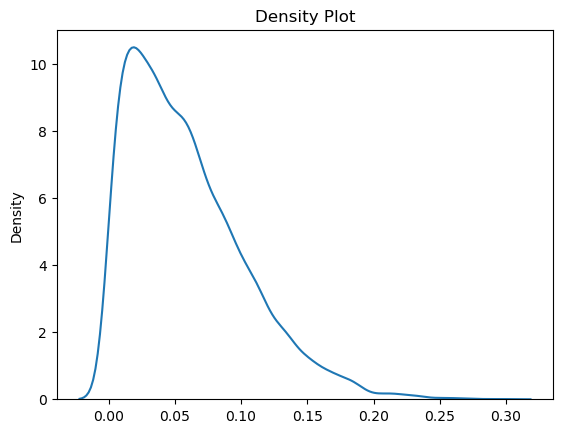

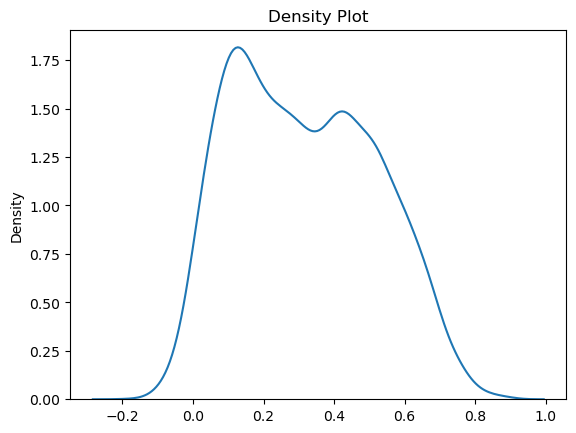

: 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(np.abs(scores-y_full.cpu().numpy()))
plt.title("Density Plot")
plt.show()

sns.kdeplot(sims_all)
plt.title("Density Plot")
plt.show()

## Inference on Validation

In [ ]:
raw = load_dataset(DATASET_ID)
print(raw)
raw = raw['validation']
# raw = raw.select(range(min(MAX_SAMPLES, len(raw))))
print(f'Dataset length: {len(raw)}')

features_val = []
# labels_clf = []
labels_reg_val = []
# sims_all = []
# f1s_all = []

results_val = []

for start in tqdm(range(0, len(raw), BATCH_SIZE), desc="Generating"):
    batch = raw[start:start + BATCH_SIZE]
    prompts = [make_prompt2(c, q) for c, q in zip(batch["context"], batch["question"])]

    # preds, token_lps_list, results = generate_with_token_logprobs(prompts)  # batch
    preds, token_lps_list, r = generate_with_token_logprobs(prompts, return_results=True)

    # SQuAD golds are lists of acceptable spans
    gold_lists = [ans["text"] if "text" in ans else [""] for ans in batch["answers"]]

    for i, (pred, golds, lps) in enumerate(zip(preds, gold_lists, token_lps_list)):  # traverse each sample in batch
        
        r[i]['gold_answer'] = golds[0]

        # print('Predicted text:', pred)
        # print('Gold text:', golds)
        feat = build_posthoc_quantile_features(lps)
        sim = max_gold_similarity(pred, golds)
        # y_sim_binary = int(sim >= SIM_THRESHOLD)
        # y_sim = float(np.clip(sim, 0.0, 1.0))  # regression!
        y_sim = float(np.clip((sim + 1.0) / 2.0, 0.0, 1.0))

        # f1 = squad_max_f1(pred, golds)
        # # f1 = bert_score(pred, golds)
        # y_f1 = int(f1 >= SIM_THRESHOLD)
        # y_f1 = f1  # regression!

        features_val.append(feat)
        # # labels.append(y_f1)
        # labels_clf.append(y_sim_binary)
        labels_reg_val.append(y_sim)
        # sims_all.append(sim)
        # f1s_all.append(f1)
    
    results_val.extend(r) if BATCH_SIZE > 1 else results.append(r)
        

# X = np.stack(features).astype(np.float32)  # (N, 22)

# best_mlp.eval()
# with torch.inference_mode():
#     # test_scores = torch.sigmoid(best_mlp(to_tensor(X_test_std, DEVICE))).cpu().numpy()
#     scores = torch.sigmoid(
#         best_mlp(to_tensor(np.stack(features).astype(np.float32), DEVICE))
#         ).detach().cpu().numpy()

# print("\nExample router scores (higher = more confident 'correct'):")
# for i in range(min(20, len(scores))):
#     print(f"score={scores[i]:.3f} | y_int={int(y_full[i])} | y={(y_full[i])}")
#     # print(f"score={test_scores[i]:.3f} | y={(y_test[i])} | abs difference={np.abs(test_scores[i]-y_test[i]):.3f}")  # regression

# assert len(scores) == len(results)
# for i in range(len(results)):
#     results[i]['pred_confidence'] = scores[i]
#     results[i]['sim_with_gold'] = labels_reg[i]

In [ ]:
best_clf_mlp = torch.load('quantile_mlp_clf.pt', weights_only=False).to(DEVICE)
best_reg_mlp = torch.load('quantile_mlp_reg.pt', weights_only=False).to(DEVICE)

best_clf_mlp.eval()
best_reg_mlp.eval()
with torch.inference_mode():
    # test_scores = torch.sigmoid(best_mlp(to_tensor(X_test_std, DEVICE))).cpu().numpy()
    clf_scores_val = torch.sigmoid(
        best_clf_mlp(to_tensor(np.stack(features_val).astype(np.float32), DEVICE))
        ).detach().cpu().numpy()
    reg_scores_val = torch.sigmoid(
        best_reg_mlp(to_tensor(np.stack(features_val).astype(np.float32), DEVICE))
        ).detach().cpu().numpy()

assert len(clf_scores) == len(results) == len(reg_scores)
for i in range(len(results)):
    results_val[i]['pred_confidence_clf'] = clf_scores_val[i]
    results_val[i]['pred_confidence_reg'] = reg_scores_val[i]
    results_val[i]['sim_with_gold'] = labels_reg_val[i]
    results_val[i]['binary_with_gold'] = int(labels_reg_val[i] >= SIM_THRESHOLD)

In [ ]:
results_val

In [ ]:
with open('squad_validation_gemma3-1b-it_profiler.pkl', 'wb') as f:
    pickle.dump(results_val, f)

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# sns.kdeplot(np.abs(scores-y_full.cpu().numpy()))
# plt.title("Density Plot")
# plt.show()

# sns.kdeplot(sims_all)
# plt.title("Density Plot")
# plt.show()

# ********************************************************